In [1]:
import os
# Find the latest version of spark 3.0  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
spark_version = 'spark-3.0.3'
#spark_version = 'spark-3.<enter version>'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:2 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:13 http://ppa.launchpad.net/graphics-driver

In [2]:
# First, enter the following code to download a Postgres driver that will allow Spark to interact with Postgres:
!wget https://jdbc.postgresql.org/download/postgresql-42.2.16.jar

--2021-08-02 06:24:45--  https://jdbc.postgresql.org/download/postgresql-42.2.16.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1002883 (979K) [application/java-archive]
Saving to: ‘postgresql-42.2.16.jar.4’

postgresql-42.2.16. 100%[===================>] 979.38K  --.-KB/s    in 0.1s    

2021-08-02 06:24:46 (6.60 MB/s) - ‘postgresql-42.2.16.jar.4’ saved [1002883/1002883]



In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Final_data").config("spark.driver.extraClassPath","/content/postgresql-42.2.16.jar").getOrCreate()

In [4]:
# Load in a sql functions
from pyspark.sql.functions import col, avg, sum, count, rand, randn, to_timestamp, format_number

In [5]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url = "https://tq2cutebucket.s3.us-west-1.amazonaws.com/final_data.csv"
spark.sparkContext.addFile(url)
df = spark.read.option("encoding", "UTF-8").csv(SparkFiles.get("final_data.csv"), sep=",", header=True, inferSchema=True)
df.show()

+------------+--------------------+------------+--------+--------------+------------+---------+--------+---+----------+---------+---------+---------+---+---------+---------+----------+----------+--------------+--------------+----------+
|  MLS_Number|      Street_Address|        City|Zip_Code|        county|County_Index|SqFtTotal|Lot_Size|Age|BathsTotal|BedsTotal|BathsFull|BathsHalf|DOM|Year_List|Year_Sold|List_Price|Sale_Price|  Listing_Date|     Sale_Date|Year_Built|
+------------+--------------------+------------+--------+--------------+------------+---------+--------+---+----------+---------+---------+---------+---+---------+---------+----------+----------+--------------+--------------+----------+
|  BE40950609|   2724 Foxglove Ct |  Pleasanton|   94588|       Alameda|           8|     2051|  2949.0| 23|         3|        4|        2|        1|  6|     2021|     2021|   1450000|   1625000|5/19/2021 0:00|5/25/2021 0:00|      1998|
|  ML81845215|  7873 Chestnut WAY |  Pleasanton|   9

In [6]:
# import sql function pyspark
import pyspark.sql.functions as f

# null values in each column
data_agg = df.agg(*[f.count(f.when(f.isnull(c), c)).alias(c) for c in df.columns])
data_agg.show()

+----------+--------------+----+--------+------+------------+---------+--------+---+----------+---------+---------+---------+---+---------+---------+----------+----------+------------+---------+----------+
|MLS_Number|Street_Address|City|Zip_Code|county|County_Index|SqFtTotal|Lot_Size|Age|BathsTotal|BedsTotal|BathsFull|BathsHalf|DOM|Year_List|Year_Sold|List_Price|Sale_Price|Listing_Date|Sale_Date|Year_Built|
+----------+--------------+----+--------+------+------------+---------+--------+---+----------+---------+---------+---------+---+---------+---------+----------+----------+------------+---------+----------+
|         0|             0|  44|       0|     0|           0|        0|       0|  0|         0|        0|        0|        0|  0|        0|        0|         0|         0|           0|        0|         0|
+----------+--------------+----+--------+------+------------+---------+--------+---+----------+---------+---------+---------+---+---------+---------+----------+----------+-----

In [7]:
#import pandas
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
df.count()

4269

In [8]:
df.printSchema()

root
 |-- MLS_Number: string (nullable = true)
 |-- Street_Address: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Zip_Code: integer (nullable = true)
 |-- county: string (nullable = true)
 |-- County_Index: integer (nullable = true)
 |-- SqFtTotal: integer (nullable = true)
 |-- Lot_Size: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- BathsTotal: integer (nullable = true)
 |-- BedsTotal: integer (nullable = true)
 |-- BathsFull: integer (nullable = true)
 |-- BathsHalf: integer (nullable = true)
 |-- DOM: integer (nullable = true)
 |-- Year_List: integer (nullable = true)
 |-- Year_Sold: integer (nullable = true)
 |-- List_Price: integer (nullable = true)
 |-- Sale_Price: integer (nullable = true)
 |-- Listing_Date: string (nullable = true)
 |-- Sale_Date: string (nullable = true)
 |-- Year_Built: integer (nullable = true)



In [9]:
# Transpose for easy reading, but it takes lots of times
# df.describe().toPandas().transpose()

In [10]:
# Select the column needed
#reg_df = df.select('MLS_Number','Street_Address','City','Zip_Code','county','County_Index','SqFtTotal','Lot_Size','Age','BathsTotal','BedsTotal','BathsFull','BathsHalf','DOM','Year_List','Year_Sold','List_Price','Sale_Price','Listing_Date','Sale_Date','Year_Built')
reg_df = df.select('County_Index','SqFtTotal','Lot_Size','Age','BedsTotal','BathsTotal','DOM','Year_Sold','List_Price','Sale_Price')
reg_df.show()
reg_df.count()

+------------+---------+--------+---+---------+----------+---+---------+----------+----------+
|County_Index|SqFtTotal|Lot_Size|Age|BedsTotal|BathsTotal|DOM|Year_Sold|List_Price|Sale_Price|
+------------+---------+--------+---+---------+----------+---+---------+----------+----------+
|           8|     2051|  2949.0| 23|        4|         3|  6|     2021|   1450000|   1625000|
|           8|     1650|  7763.0| 48|        4|         2|  8|     2021|   1228888|   1650000|
|          11|     2216|  6098.0|  6|        4|         2| 37|     2020|    489000|    484000|
|           4|     1404|  8346.0| 29|        3|         2|  2|     2021|    520000|    520000|
|           4|     2574|  6726.0| 32|        4|         3|  5|     2021|    559999|    595000|
|           1|     2389|  6098.0|  7|        3|         3|  6|     2021|    699900|    800000|
|           0|     2189|  3120.0| 47|        3|         2|  4|     2021|    970000|   1056500|
|          10|     1142|  4999.0| 50|        3|   

4269

In [11]:
type(reg_df)

pyspark.sql.dataframe.DataFrame

In [12]:
reg_pd_df=reg_df.toPandas()
reg_pd_df

,County_Index,SqFtTotal,Lot_Size,Age,BedsTotal,BathsTotal,DOM,Year_Sold,List_Price,Sale_Price
0,8,2051,2949.0,23,4,3,6,2021,1450000,1625000
1,8,1650,7763.0,48,4,2,8,2021,1228888,1650000
2,11,2216,6098.0,6,4,2,37,2020,489000,484000
3,4,1404,8346.0,29,3,2,2,2021,520000,520000
4,4,2574,6726.0,32,4,3,5,2021,559999,595000
...,...,...,...,...,...,...,...,...,...,...
4264,5,2528,348474.0,25,2,3,8,2021,675000,675000
4265,5,1580,10095.0,35,4,2,32,2021,578000,578000
4266,5,1899,4401.0,33,2,3,15,2021,750000,750000
4267,11,1830,27007.0,74,5,2,426,2020,375000,311770


In [13]:
data_array = np.array(reg_df.collect())
data_array

array([[8.000000e+00, 2.051000e+03, 2.949000e+03, ..., 2.021000e+03,
        1.450000e+06, 1.625000e+06],
       [8.000000e+00, 1.650000e+03, 7.763000e+03, ..., 2.021000e+03,
        1.228888e+06, 1.650000e+06],
       [1.100000e+01, 2.216000e+03, 6.098000e+03, ..., 2.020000e+03,
        4.890000e+05, 4.840000e+05],
       ...,
       [5.000000e+00, 1.899000e+03, 4.401000e+03, ..., 2.021000e+03,
        7.500000e+05, 7.500000e+05],
       [1.100000e+01, 1.830000e+03, 2.700700e+04, ..., 2.020000e+03,
        3.750000e+05, 3.117700e+05],
       [4.000000e+00, 1.100000e+03, 7.345000e+03, ..., 2.021000e+03,
        2.999950e+05, 3.850000e+05]])

In [14]:
X = data_array[1:4269:,0:9]
y = data_array[1:4269:,9:10]
print(X)
print(y)

[[8.000000e+00 1.650000e+03 7.763000e+03 ... 8.000000e+00 2.021000e+03
  1.228888e+06]
 [1.100000e+01 2.216000e+03 6.098000e+03 ... 3.700000e+01 2.020000e+03
  4.890000e+05]
 [4.000000e+00 1.404000e+03 8.346000e+03 ... 2.000000e+00 2.021000e+03
  5.200000e+05]
 ...
 [5.000000e+00 1.899000e+03 4.401000e+03 ... 1.500000e+01 2.021000e+03
  7.500000e+05]
 [1.100000e+01 1.830000e+03 2.700700e+04 ... 4.260000e+02 2.020000e+03
  3.750000e+05]
 [4.000000e+00 1.100000e+03 7.345000e+03 ... 5.000000e+00 2.021000e+03
  2.999950e+05]]
[[1650000.]
 [ 484000.]
 [ 520000.]
 ...
 [ 750000.]
 [ 311770.]
 [ 385000.]]


In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, random_state=1)

In [16]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4182, 9) (86, 9) (4182, 1) (86, 1)


In [17]:
from keras.models import Sequential
from keras.layers import Dense

**GOOD WORKING MODEL**


In [18]:
model = Sequential([
    Dense(9, activation='relu', input_shape=(9,)),
    Dense(1, activation='relu')
])


In [19]:
model.compile(optimizer='Adam',
              loss='MSE',
              metrics=['MSE'])

#model.compile(optimizer='sgd',
#              loss='binary_crossentropy',
#              metrics=['accuracy'])

# optimizer: RMSPROP, SGD, AdaGrad, Adadelta, Adam
# loss function: MSE, BCE, CC, SCC
# metrics: MSE, accuracy, Log Loss,

In [20]:
hist = model.fit(X_train, y_train,
          batch_size=32, epochs=50,
          validation_data=(X_test, y_test))

Epoch 1/50
131/131 [==============================] - 13s 4ms/step - loss: 2929632298449.4546 - MSE: 2929632298449.4546 - val_loss: 2017702182912.0000 - val_MSE: 2017702182912.0000
Epoch 2/50
131/131 [==============================] - 0s 1ms/step - loss: 2908757064735.0303 - MSE: 2908757064735.0303 - val_loss: 2017702182912.0000 - val_MSE: 2017702182912.0000
Epoch 3/50
131/131 [==============================] - 0s 1ms/step - loss: 2515622339304.7271 - MSE: 2515622339304.7271 - val_loss: 2017702182912.0000 - val_MSE: 2017702182912.0000
Epoch 4/50
131/131 [==============================] - 0s 2ms/step - loss: 2279255568508.1211 - MSE: 2279255568508.1211 - val_loss: 2017702182912.0000 - val_MSE: 2017702182912.0000
Epoch 5/50
131/131 [==============================] - 0s 1ms/step - loss: 2200501767571.3940 - MSE: 2200501767571.3940 - val_loss: 2017702182912.0000 - val_MSE: 2017702182912.0000
Epoch 6/50
131/131 [==============================] - 0s 1ms/step - loss: 2564579292253.0908 - MSE:

In [21]:
# the predict() method is used to generate predictions
y_pred = model.predict(X_test)
print(y_pred.shape)
print(y_test.shape)

(86, 1)
(86, 1)


In [22]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, y_pred.shape)

(4182, 9) (86, 9) (4182, 1) (86, 1) (86, 1)


In [23]:
test_data_df = pd.DataFrame(X_test,columns=["County_Index","SqFtTotal",'Lot_Size','Age',	'BedsTotal',	'BathsTotal','DOM','Year_Sold','List_Price'])

In [24]:
#df = pd.DataFrame.from_records([{ 'A':a,'B':b }], index='A')
import pandas as pd
good_result_df = pd.DataFrame({"Sale_Price": [x[0] for x in y_test], "Prediction": [x[0] for x in y_pred]})
good_result_df.head()

,Sale_Price,Prediction
0,502000.0,0.0
1,740000.0,0.0
2,1500000.0,0.0
3,1608000.0,0.0
4,945000.0,0.0


In [25]:
final_result_data_df = test_data_df.merge(good_result_df,how='left', left_index=True, right_index=True)
final_result_data_df

,County_Index,SqFtTotal,Lot_Size,Age,BedsTotal,BathsTotal,DOM,Year_Sold,List_Price,Sale_Price,Prediction
0,4.0,1504.0,10019.0,58.0,3.0,2.0,4.0,2021.0,459000.0,502000.0,0.0
1,14.0,1862.0,5850.0,60.0,4.0,3.0,9.0,2021.0,725000.0,740000.0,0.0
2,0.0,1917.0,5341.0,56.0,3.0,3.0,8.0,2021.0,1349000.0,1500000.0,0.0
3,0.0,3857.0,11019.0,33.0,5.0,4.0,9.0,2021.0,1495000.0,1608000.0,0.0
4,17.0,1840.0,8008.0,63.0,3.0,2.0,28.0,2021.0,939900.0,945000.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
81,2.0,1964.0,6991.0,57.0,4.0,2.0,9.0,2021.0,1085000.0,1078500.0,0.0
82,2.0,1231.0,6114.0,66.0,4.0,2.0,14.0,2021.0,650000.0,720000.0,0.0
83,0.0,1136.0,12427.0,93.0,3.0,1.0,0.0,2021.0,545000.0,550000.0,0.0
84,6.0,2115.0,11773.0,37.0,4.0,3.0,5.0,2021.0,875000.0,905000.0,0.0


In [26]:
#df['cost'] = df['cost'].map('${:,.2f}'.format)
final_result_data_df['Prediction'] = final_result_data_df['Prediction'].map('{:,.2f}'.format)
final_result_data_df

,County_Index,SqFtTotal,Lot_Size,Age,BedsTotal,BathsTotal,DOM,Year_Sold,List_Price,Sale_Price,Prediction
0,4.0,1504.0,10019.0,58.0,3.0,2.0,4.0,2021.0,459000.0,502000.0,0.00
1,14.0,1862.0,5850.0,60.0,4.0,3.0,9.0,2021.0,725000.0,740000.0,0.00
2,0.0,1917.0,5341.0,56.0,3.0,3.0,8.0,2021.0,1349000.0,1500000.0,0.00
3,0.0,3857.0,11019.0,33.0,5.0,4.0,9.0,2021.0,1495000.0,1608000.0,0.00
4,17.0,1840.0,8008.0,63.0,3.0,2.0,28.0,2021.0,939900.0,945000.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...
81,2.0,1964.0,6991.0,57.0,4.0,2.0,9.0,2021.0,1085000.0,1078500.0,0.00
82,2.0,1231.0,6114.0,66.0,4.0,2.0,14.0,2021.0,650000.0,720000.0,0.00
83,0.0,1136.0,12427.0,93.0,3.0,1.0,0.0,2021.0,545000.0,550000.0,0.00
84,6.0,2115.0,11773.0,37.0,4.0,3.0,5.0,2021.0,875000.0,905000.0,0.00


In [27]:
#Create PySpark DataFrame from Pandas
final_result_data_df = spark.createDataFrame(final_result_data_df)
type(final_result_data_df)

pyspark.sql.dataframe.DataFrame

In [28]:
# R squared
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

-1.2521362167631418

**When R squared is 0.94 it is a pretty good model.  Basically, this model explain about 94% in the variation of the price.  Note: it does not explain all, but only 94%.**

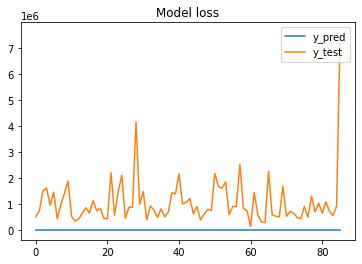

In [29]:
import matplotlib.pyplot as plt
plt.plot(y_pred)
plt.plot(y_test)
plt.title('Model loss')
#plt.ylabel('Loss')
#plt.xlabel('Epoch')
plt.legend(['y_pred', 'y_test'], loc='upper right')
plt.show()

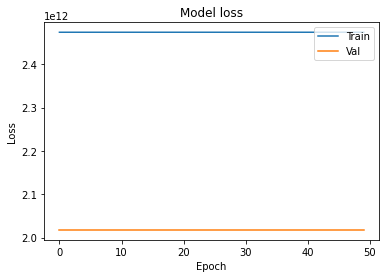

In [30]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [31]:
# Store environmental variable
from getpass import getpass
password = getpass('Enter database password')
# Configure settings for RDS
mode = "append"
jdbc_url="jdbc:postgresql://database-1.cvmp56um73d3.us-west-1.rds.amazonaws.com:5432/Final_Project2_db"
config = {"user":"postgres",
          "password": password,
          "driver":"org.postgresql.Driver"}

Enter database password··········


In [32]:
# Write DataFrame to active_user table in RDS
final_result_data_df.write.jdbc(url=jdbc_url, table='final_neural_network_housing', mode=mode, properties=config)